In [ ]:
#!pip install sentence_transformers
from sentence_transformers import SentenceTransformer,InputExample,losses,evaluation,util
import pandas as pd
import numpy as np
import torch
import argparse
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
from sklearn import preprocessing
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
print("hi")

hi


In [ ]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
# print all output to a file
import sys
import os
import datetime
now = datetime.datetime.now()
data = 'R8_toy'
random_pairs = 20
positive_pairs = 5
EPS = 1e-9
model_name = 'all-MiniLM-L6-v2'
# model_name = 'all-mpnet-base-v2'
data_dir = 'data/'+data+'/'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using device:', device)
sys.stdout = open('output_'+ data+'_baseline_'+model_name+now.strftime("%Y-%m-%d-%H-%M-%S")+'.txt', 'w')
#model = SentenceTransformer(model_name)

Using device: cuda


In [ ]:
def make_training_pairs(X,y):
    train_examples = []
    # select 20 random sentences and make pairs accordingly(both labels 1,0)
    # select 5 sentences from same class as s,
    for i in range(len(X)):
        random_indices = np.random.choice(len(X), random_pairs, replace=False)
        for j in random_indices:
            train_examples.append(InputExample(texts=[X[i], X[j]], label=float(y[i]==y[j])))
        same_class_indices = np.where(y==y[i])[0]
        random_indices = np.random.choice(same_class_indices, positive_pairs, replace=True)
        for j in random_indices:
            train_examples.append(InputExample(texts=[X[i], X[j]], label=1.0))
    return train_examples

In [ ]:
train_examples = make_training_pairs(X_train,y_train)

In [ ]:
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=32)

In [ ]:
print("hi")

In [ ]:
train = pd.read_csv(r'/content/train.csv')
train = train.sample(frac=1).reset_index(drop=True)
label_encoder = preprocessing.LabelEncoder()
X_train = train['text'].values
y_train = train['label'].values
y_train = label_encoder.fit_transform(y_train)

In [ ]:
val = pd.read_csv(r'/content/val.csv')
X_val = val['text'].values
y_val = val['label'].values
y_val = label_encoder.fit_transform(y_val)
#print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)
num_labels = len(np.unique(y_train))
#print(num_labels)

In [ ]:
test = pd.read_csv(r'/content/test.csv')
X_test = test['text'].values
y_test = test['label'].values
y_test = label_encoder.fit_transform(y_test)

In [ ]:
X_val[0], y_val[0]

('gould gld completes sale of french battery unit gould inc said it has completed the sale of its french battery business compagnie francaise d electro chimie to a group of investors including the unit s employees and gnb inc of minnesota gould did not disclose terms of the deal gould said the move is part of its previously announced plan to divest assets unrelated to its computer and electronics businesses reuter',
 0)

In [ ]:
print("hi")

In [ ]:
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

In [ ]:
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
X_train = X_train.tolist()
X_val = X_val.tolist()
X_test = X_test.tolist()

In [ ]:
total_X = X_train + X_val+ X_test

In [ ]:
total_X = np.array(total_X)

In [ ]:
total_X.shape

(759,)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GraphLearningLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.a = nn.Parameter(torch.randn(size=[1, 384])).to(device)  # Learnable parameter

    def calculate_sim_matrix(self, embeddings):
        # Calculate the pairwise absolute difference between embeddings
        # Use broadcasting for efficient computation
        diff = embeddings.unsqueeze(1) - embeddings.unsqueeze(0)  # [N, N, D]
        abs_diff = torch.abs(diff)  # Absolute difference

        # Compute the similarity matrix
        sub_emb = abs_diff.permute(0, 1, 2).reshape(-1, embeddings.shape[-1]).T  # [D, N*N]
        sub_emb = sub_emb.to(device)
        temp = torch.exp(F.relu(self.a @ sub_emb))  # [1, N*N]
        sim_matrix = temp.reshape(len(embeddings), len(embeddings))  # [N, N]

        # Normalize the similarity matrix
        sim_matrix = sim_matrix / sim_matrix.sum()
        return sim_matrix

    def forward(self, embeddings):
        # Calculate similarity matrix
        my_sim = self.calculate_sim_matrix(embeddings).to(device)

        # Compute the loss
        diff = embeddings.unsqueeze(1) - embeddings.unsqueeze(0)  # [N, N, D]
        norms = torch.norm(diff, dim=-1).to(device)  # [N, N]
        my_loss = (norms * my_sim).sum()  # Weighted sum of norms
        return my_loss


In [ ]:
import math
class GraphConvolution(nn.Module):

    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'

In [ ]:
SEED = 123
torch.manual_seed(SEED)
np.random.seed(SEED)

test_layer = GraphConvolution(5, 4)
print("Weight Matrix", test_layer.weight)
print("Bias", test_layer.bias )
print(test_layer.in_features,test_layer.out_features)

In [ ]:
class GCN(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout):
        super(GCN, self).__init__()

        self.gc1 = GraphConvolution(nfeat, nhid)
        self.gc2 = GraphConvolution(nhid, nclass)
        self.dropout = dropout

    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.gc2(x, adj)
        return F.log_softmax(x, dim=1)

In [ ]:
def intialize_model(nfeat, hidden, c, dropout, lr, wd):
  # Model and optimizer
  gcn_model = GCN(nfeat=nfeat,
              nhid=hidden,
              nclass=c,
              dropout=dropout).to(device)
  gcn_optimizer = optim.Adam(gcn_model.parameters(),
                        lr=lr, weight_decay=wd)
  sbert_model = SentenceTransformer(model_name).to(device)
  sbert_optimizer = optim.Adam(sbert_model.parameters(),
                        lr=lr, weight_decay=wd)
  return gcn_model, gcn_optimizer, sbert_model, sbert_optimizer


In [ ]:
def accuracy(output, labels):
  preds   = output.max(1)[1].type_as(labels)
  print(preds, labels)
  correct = preds.eq(labels).double()
  correct = correct.sum()
  return correct / len(labels)

In [ ]:
import scipy.sparse as sp
def normalize(adj):
    """Symmetrically normalize adjacency matrix."""
    adj = sp.coo_matrix(adj)
    rowsum = np.array(adj.sum(1))
    d_inv_sqrt = np.power(rowsum, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
    return adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt).tocoo()

In [ ]:
def sparse_mx_to_torch_sparse_tensor(sparse_mx):
  sparse_mx = sparse_mx.tocoo().astype(np.float32)
  indices = torch.from_numpy(np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
  values = torch.from_numpy(sparse_mx.data)
  shape = torch.Size(sparse_mx.shape)
  return torch.sparse.FloatTensor(indices, values, shape)

In [ ]:
sbert_model = SentenceTransformer(model_name).to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
embeddings = sbert_model.encode(total_X)

In [ ]:
embeddings.shape

(759, 384)

In [ ]:
embeddings = torch.tensor(embeddings).to("cpu")
gl_loss = GraphLearningLoss()
ans = gl_loss.calculate_sim_matrix(embeddings).to("cpu")
ans = sp.coo_matrix(ans.detach().numpy())


In [ ]:
ans = normalize(ans + sp.eye(ans.shape[0]))

In [ ]:
ans = sparse_mx_to_torch_sparse_tensor(ans)

<ipython-input-25-d42694959cde>:6: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:651.)
  return torch.sparse.FloatTensor(indices, values, shape)


In [ ]:
#X_train_emb.shape[1], h, labels.max().item() + 1
embeddings = torch.tensor(embeddings).to("cpu")
gcn_model = GCN(nfeat=384,
              nhid=16,
              nclass=8,
              dropout=0.3)
output = gcn_model(embeddings, ans)

<ipython-input-32-6847ccc3f8ed>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings = torch.tensor(embeddings).to("cpu")


In [ ]:
output.max(1)[1][:60]

tensor([7, 7, 3, 3, 3, 3, 7, 7, 3, 1, 1, 1, 3, 3, 7, 1, 3, 1, 3, 7, 7, 5, 3, 7,
        7, 7, 3, 5, 3, 7, 3, 3, 1, 5, 3, 7, 1, 1, 7, 1, 7, 3, 7, 7, 7, 7, 3, 7,
        7, 1, 3, 1, 1, 1, 7, 3, 3, 3, 3, 1])

In [ ]:
def train(gcn_model, gcn_optimizer, sbert_model, sbert_optimizer, total_X, gl_loss, epoch, losses, acc_list,final_train=False):
    best_acc = 0
    t = time.time()
    sbert_model.train()
    gcn_model.train()
    gcn_optimizer.zero_grad()
    sbert_optimizer.zero_grad()
    embeddings = sbert_model.encode(total_X)
    embeddings = torch.tensor(embeddings).to(device)
    loss_term_2 = 1e-4*gl_loss(embeddings)
    adj = sp.coo_matrix(gl_loss.calculate_sim_matrix(embeddings).to("cpu").detach().numpy())
    adj = normalize(adj + sp.eye(adj.shape[0]))
    adj = sparse_mx_to_torch_sparse_tensor(adj).to(device)
    output = gcn_model(embeddings, adj)
    #print(output[0])
    loss_term_1 = F.nll_loss(output[:len(X_train)], y_train[:len(X_train)])
    loss_train = loss_term_1 + loss_term_2
    print(loss_train)
    acc_train = accuracy(output[:len(X_train)], y_train[:len(X_train)])
    print(acc_train)
    loss_train.backward()
    gcn_optimizer.step()
    sbert_optimizer.step()
    losses.append(loss_train.item())
    acc_list.append(acc_train.item())

    '''model.eval()
    output = model(features, adj)

    loss_val = F.nll_loss(output[idx_val], labels[idx_val])
    acc_val = accuracy(output[idx_val], labels[idx_val])
    if acc_val > best_acc:
      best_acc = acc_val
    if final_train:
      if epoch % 10==0:
        print('Epoch: {:04d}'.format(epoch+1),
              'loss_train: {:.4f}'.format(loss_train.item()),
              'acc_train: {:.4f}'.format(acc_train.item()),
              'loss_val: {:.4f}'.format(loss_val.item()),
              'acc_val: {:.4f}'.format(acc_val.item()),
              'time: {:.4f}s'.format(time.time() - t))

    return loss_train.item(), loss_val.item(), best_acc.item()'''

In [ ]:
h = 16
d=0.5
l = 5e-3
w = 5e-3
labels = torch.unique(y_train)
gcn_model, gcn_optimizer, sbert_model, sbert_optimizer = intialize_model(384, h, labels.max().item() + 1, d, l, w)

In [ ]:
import time
#gl_loss = GraphLearningLoss().to(device)
losses = []
acc_list = []
gl_loss = GraphLearningLoss()

In [ ]:
for i in range(30):
  train(gcn_model, gcn_optimizer, sbert_model, sbert_optimizer, total_X, gl_loss, 1, losses, acc_list, final_train=False)

In [ ]:
for i in range(len(losses)):
  losses[i] = losses[i].item()

Text(0.5, 1.0, 'Epochs vs Training Loss')

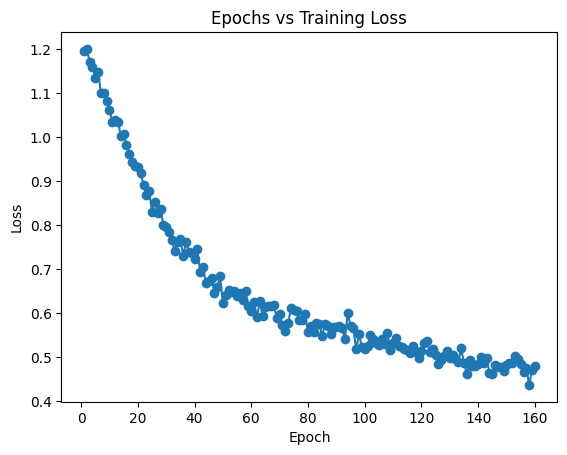

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(losses) + 1), losses, marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epochs vs Training Loss')

Text(0.5, 1.0, 'Epochs vs Training Loss')

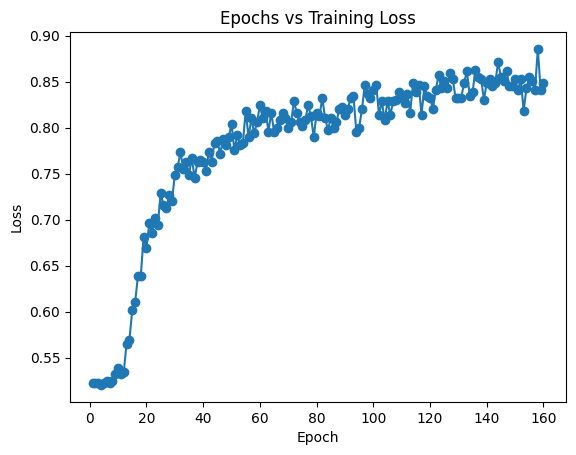

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(acc_list) + 1), acc_list, marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epochs vs Training Loss')

In [ ]:
a_from_training = gl_loss.a

In [ ]:
a_from_training.shape

torch.Size([1, 384])

In [ ]:
torch.save(gl_loss.state_dict(), "gl_loss_for_task_2.pth")

In [ ]:
torch.save(sbert_model.state_dict(), "sbert_model_for_task_2.pth")

In [ ]:
torch.save(gcn_model.state_dict(), "gcn_model_for_task_2.pth")

In [ ]:
sbert_model.load_state_dict(torch.load(r"/content/sbert_model_for_task_2.pth", weights_only=True, map_location=device))
gcn_model.load_state_dict(torch.load(r"/content/gcn_model_for_task_2.pth", weights_only=True, map_location=device))

<All keys matched successfully>

In [ ]:
embeddings = sbert_model.encode(total_X)
embeddings = torch.tensor(embeddings).to(device)


In [ ]:
#gl_loss = GraphLearningLoss()
#loss_term_2 = 1e-4*gl_loss(embeddings)
adj = sp.coo_matrix(gl_loss.calculate_sim_matrix(embeddings).to("cpu").detach().numpy())
adj = normalize(adj + sp.eye(adj.shape[0]))
adj = sparse_mx_to_torch_sparse_tensor(adj).to(device)
output = gcn_model(embeddings, adj)

In [ ]:
acc_test_with_random_a = accuracy(output[len(X_train)+len(X_val):len(X_train)+len(X_val)+len(X_test)], y_test)

In [ ]:
acc_test_with_random_a

tensor(0.8333, device='cuda:0', dtype=torch.float64)

In [ ]:
gl_loss_new = GraphLearningLoss()
#loss_term_2 = 1e-4*gl_loss(embeddings)
adj = sp.coo_matrix(gl_loss.calculate_sim_matrix(embeddings).to("cpu").detach().numpy())
adj = normalize(adj + sp.eye(adj.shape[0]))
adj = sparse_mx_to_torch_sparse_tensor(adj).to(device)
output = gcn_model(embeddings, adj)

In [ ]:
acc_test_without_random_a = accuracy(output[len(X_train)+len(X_val):len(X_train)+len(X_val)+len(X_test)], y_test)

In [ ]:
acc_test_without_random_a

tensor(0.8657, device='cuda:0', dtype=torch.float64)

In [ ]:
!pip install torcheval

In [ ]:
from torcheval.metrics.functional import multiclass_f1_score
multiclass_f1_score(output[len(X_train)+len(X_val):len(X_train)+len(X_val)+len(X_test)], y_test[:], num_classes=8, average=None)

tensor([0.8919, 0.6000, 0.9427, 0.0000, 0.4000, 0.3636, 0.0000, 0.6667],
       device='cuda:0')